In [9]:
import mlrun
project_name = "test-serv-with-remote"
# get/create a project and register the data prep and trainer function in it
project = mlrun.get_or_create_project(
    name=project_name, user_project=False, context="./"
)

> 2022-12-12 09:10:43,808 [info] loaded project test-serv-with-remote from MLRun DB


<a id="serving-function"></a>
## Create and test the Serving Function


In [9]:
# mlrun: start-code

In [4]:
from cloudpickle import load
from typing import List
import numpy as np
from mlrun.frameworks.lgbm import LGBMModelServer

import mlrun

class MyReggressor(LGBMModelServer):
    pass

In [17]:
# mlrun: end-code

In [10]:
remote_func_name = "predict_remote"
fn_remote = mlrun.code_to_function(remote_func_name,
                                   project=project_name,
                                   kind="serving", 
                                   image="mlrun/ml-models")

fn_remote.add_model("lgbm_ny_taxi", class_name="MyReggressor", model_path=project.get_artifact('lgbm_ny_taxi').uri)

remote_addr = fn_remote.deploy()

> 2022-12-12 09:10:49,361 [info] Starting remote function deploy
2022-12-12 09:10:49  (info) Deploying function
2022-12-12 09:10:49  (info) Building
2022-12-12 09:10:49  (info) Staging files and preparing base images
2022-12-12 09:10:49  (info) Building processor image
2022-12-12 09:13:04  (info) Build complete
2022-12-12 09:13:14  (info) Function deploy complete
> 2022-12-12 09:13:14,396 [info] successfully deployed function: {'internal_invocation_urls': ['nuclio-test-serv-with-remote-predict-remote.default-tenant.svc.cluster.local:8080'], 'external_invocation_urls': ['test-serv-with-remote-predict-remote-test-serv-with-remote.default-tenant.app.dev6.lab.iguazeng.com/']}


In [11]:
serving_function = project.set_function(name='serving', func='src/serving.py', image='mlrun/ml-models', kind="serving")

In [12]:
# Set the topology and get the graph object:
graph = serving_function.set_topology("flow", engine="async")

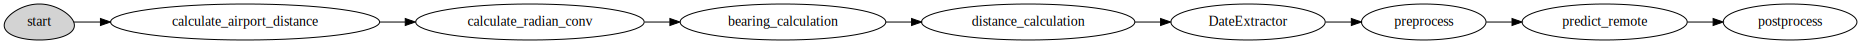

In [13]:
from mlrun.feature_store.steps import DateExtractor

# Build the serving graph:
graph.to(handler="add_airport_dist", name="calculate_airport_distance")\
     .to(handler="radian_conv_step", name="calculate_radian_conv")\
     .to(handler="sphere_dist_bear_step", name="bearing_calculation")\
     .to(handler="sphere_dist_step", name="distance_calculation")\
     .to(DateExtractor(parts=["hour", "day", 'month', "day_of_week", 'year'],timestamp_col="pickup_datetime"))\
     .to(handler="preprocess", name="preprocess")\
     .to("$remote", remote_func_name, url=f'{remote_addr}v2/models/lgbm_ny_taxi/infer', method='put')\
     .to(handler="postprocess", name="postprocess").respond()

# Plot to graph:
graph.plot(rankdir='LR')

In [18]:
# creatresponseock server (in memory simulator for the graph for testing)
server = serving_function.to_mock_server()

body = {'pickup_longitude':-73.844311, 'pickup_latitude':40.721319,
        'dropoff_longitude':-73.84161, 'dropoff_latitude': 40.712278,
        'passenger_count':1,
        'pickup_datetime': '2013-01-01T12', 'key': '2013-01-01T12'}

# simulate a user request and print the results
response_mock = server.test(path="/v2/models/lgbm_ny_taxi/infer", body=body.copy())
print(response_mock['result_str'])

predicted fare amount is 23.312114702495798


<a id="deploy-serving"></a>
## Deploy the serving Function


In [15]:
# Deploy it:
deployment = project.deploy_function(serving_function)

> 2022-12-12 09:13:14,641 [info] Starting remote function deploy
2022-12-12 09:13:14  (info) Deploying function
2022-12-12 09:13:14  (info) Building
2022-12-12 09:13:14  (info) Staging files and preparing base images
2022-12-12 09:13:14  (info) Building processor image
2022-12-12 09:15:33  (info) Build complete
2022-12-12 09:15:41  (info) Function deploy complete
> 2022-12-12 09:15:42,527 [info] successfully deployed function: {'internal_invocation_urls': ['nuclio-test-serv-with-remote-serving.default-tenant.svc.cluster.local:8080'], 'external_invocation_urls': ['test-serv-with-remote-serving-test-serv-with-remote.default-tenant.app.dev6.lab.iguazeng.com/']}


In [16]:
response = deployment.function.invoke(path='/predict', body=body.copy())
print(response)

> 2022-12-12 09:15:42,591 [info] invoking function: {'method': 'POST', 'path': 'http://nuclio-test-serv-with-remote-serving.default-tenant.svc.cluster.local:8080/predict'}
{'result': 23.312114702495798, 'result_str': 'predicted fare amount is 23.312114702495798'}


In [21]:
assert response['result_str'] == response_mock['result_str']